In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-09-20 18:27:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.72.44.156, 2600:1413:b000:390::317f, 2600:1413:b000:386::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.72.44.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   283MB/s    in 2.8s    

2022-09-20 18:27:48 (283 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip kagglecatsanddogs_5340.zip

# **Kütüphanelerin yüklenmesi**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import random
import tensorflow as tf
import seaborn as sns
import PIL
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# **DataFrame oluşturulması ve Dataframe işlemleri**

In [4]:
label = []
input_path = []

for class_name in os.listdir("PetImages"):
  for path in os.listdir("PetImages/"+class_name):
    if class_name == "Dog":
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[1], label[1])

PetImages/Dog/6248.jpg 0


In [5]:
df = pd.DataFrame()
df["images"] = input_path
df["label"] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Dog/4476.jpg,0
1,PetImages/Cat/5557.jpg,1
2,PetImages/Cat/11950.jpg,1
3,PetImages/Dog/10488.jpg,0
4,PetImages/Dog/2921.jpg,0


# **Çalışan fotoğrafların seçilmesi**

In [6]:
for i in df["images"]:
  if ".jpg" not in i:
    print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [8]:
null = []
for i in df["images"]:
  try:
    img = PIL.Image.open(i)
  except:
    null.append(i)
print(null)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

['PetImages/Cat/Thumbs.db', 'PetImages/Dog/Thumbs.db', 'PetImages/Cat/666.jpg', 'PetImages/Dog/11702.jpg']


In [9]:
df = df[df["images"] != 'PetImages/Cat/Thumbs.db']
df = df[df["images"] != 'PetImages/Dog/Thumbs.db']
df = df[df["images"] != 'PetImages/Cat/666.jpg']
df = df[df["images"] != 'PetImages/Dog/11702.jpg']

# **Fotoğrafların görselleştirilmesi**

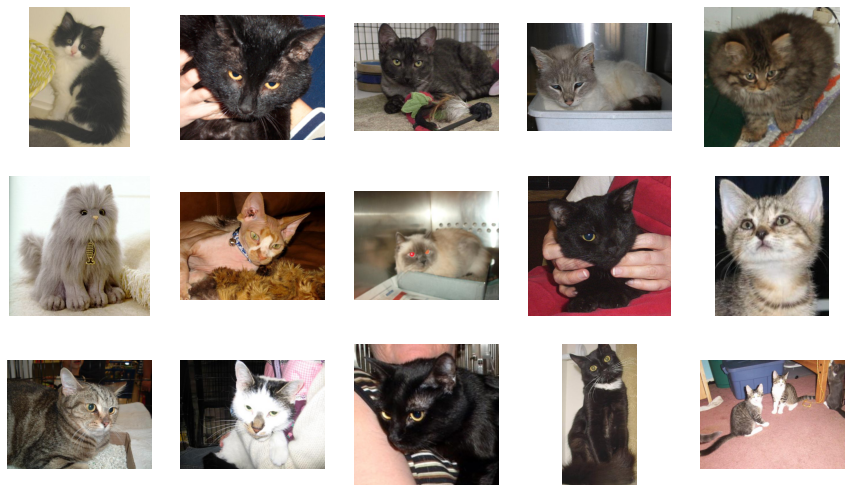

In [14]:
plt.figure(figsize=(15,15))
template =  df[df["label"]==1]["images"]
cat_random = random.randint(0,len(template))
files = template[cat_random:cat_random+15]
for index, file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.axis("off")

# **Veri Ön İşleme**

In [15]:
df["label"] = df["label"].astype("str")
df.head()

,images,label
0,PetImages/Dog/4476.jpg,0
1,PetImages/Cat/5557.jpg,1
2,PetImages/Cat/11950.jpg,1
3,PetImages/Dog/10488.jpg,0
4,PetImages/Dog/2921.jpg,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24998 entries, 0 to 25001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  24998 non-null  object
 1   label   24998 non-null  object
dtypes: object(2)
memory usage: 585.9+ KB


In [17]:
train, test = train_test_split(df, train_size = 0.8, random_state=42)

In [18]:
train_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode = "nearest"
)

In [19]:
val_generator = ImageDataGenerator(rescale= 1./255)

In [23]:
train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col="images",
    y_col="label",
    target_size=(128,128),
    batch_size = 512,
    class_mode = "binary"
)

Found 19998 validated image filenames belonging to 2 classes.


In [24]:
val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col="images",
    y_col="label",
    target_size=(128,128),
    batch_size = 512,
    class_mode = "binary"
)

Found 5000 validated image filenames belonging to 2 classes.


In [25]:
model = Sequential([
    Conv2D(16,(3,3), activation="relu", input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Conv2D(32,(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(512,activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [27]:
history = model.fit(train_iterator, epochs=5, validation_data=val_iterator)

Epoch 1/5
40/40 [==============================] - 122s 3s/step - loss: 0.6215 - accuracy: 0.6516 - val_loss: 0.5931 - val_accuracy: 0.6830
Epoch 2/5
40/40 [==============================] - 118s 3s/step - loss: 0.5736 - accuracy: 0.7003 - val_loss: 0.5223 - val_accuracy: 0.7414
Epoch 3/5
40/40 [==============================] - 119s 3s/step - loss: 0.5510 - accuracy: 0.7152 - val_loss: 0.5206 - val_accuracy: 0.7312
Epoch 4/5
40/40 [==============================] - 118s 3s/step - loss: 0.5340 - accuracy: 0.7310 - val_loss: 0.5038 - val_accuracy: 0.7470
Epoch 5/5
40/40 [==============================] - 120s 3s/step - loss: 0.5150 - accuracy: 0.7424 - val_loss: 0.4809 - val_accuracy: 0.7624


<Figure size 432x288 with 0 Axes>

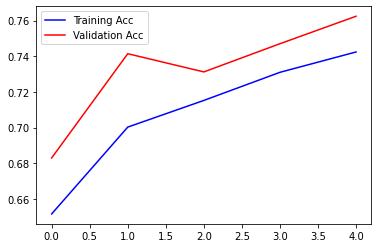

<Figure size 432x288 with 0 Axes>

In [28]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs=range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="Training Acc")
plt.plot(epochs, val_accuracy, "r", label="Validation Acc")
plt.legend()
plt.figure()